<a href="https://colab.research.google.com/github/xsong0306/fraudDetection/blob/main/IEEE_fraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load dataset and packages

In [1]:
!pip install category_encoders==2.*

     |████████████████████████████████| 82 kB 489 kB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
import xgboost as xgb

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
! pip install -q kaggle 
#to force update Kaggle API
#!pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#if Google Drive mounted with API credential
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#to check if API is working
#! kaggle datasets list

! kaggle competitions download -c ieee-fraud-detection

  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 107MB/s]
 90% 47.0M/52.2M [00:01<00:00, 21.7MB/s]
100% 52.2M/52.2M [00:01<00:00, 32.8MB/s]
 91% 53.0M/58.3M [00:02<00:00, 13.0MB/s]
100% 58.3M/58.3M [00:03<00:00, 19.6MB/s]
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 53.4MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 76.7MB/s]


In [4]:
!unzip train_identity.csv.zip
!unzip train_transaction.csv.zip

Archive:  train_identity.csv.zip
  inflating: train_identity.csv      
Archive:  train_transaction.csv.zip
  inflating: train_transaction.csv   


In [24]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [25]:
folder_path = '/content/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
train_identity = reduce_mem_usage(train_identity)
train_transaction = reduce_mem_usage(train_transaction)

#merge transaction and identity tables
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)


#Explorative data analysis

In [26]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [27]:
print(f'Shape of training dataset: {train.shape}')
print(f'Columns with null values: {train.isnull().any().sum()}\n')

print(f'Example feature value counts: \n{train.V6.value_counts(dropna=False, normalize=True).head()}\n')
print(f'{train.C10.value_counts(dropna=False, normalize=True).head()}')

Shape of training dataset: (590540, 434)
Columns with null values: 414

Example feature value counts: 
1.0    0.505685
NaN    0.472935
2.0    0.019167
3.0    0.001768
4.0    0.000305
Name: V6, dtype: float64

0.0    0.767843
1.0    0.169728
2.0    0.025295
3.0    0.010866
4.0    0.004802
Name: C10, dtype: float64


In [10]:
# close previous plots
plt.close('all')
%matplotlib inline

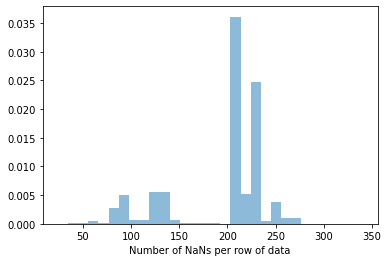

In [11]:
train_null = train.isnull().sum(axis=1)
plt.hist(train_null, density = True, bins=30, alpha=.5)
plt.xlabel('Number of NaNs per row of data');


In [32]:
print(f'Target column has {train.isFraud.isnull().sum()} null values.\n')
print(f'Class proportion: \n{train.isFraud.value_counts(normalize=True)}')

Target column has 0 null values.

Class proportion: 
0    0.96501
1    0.03499
Name: isFraud, dtype: float64


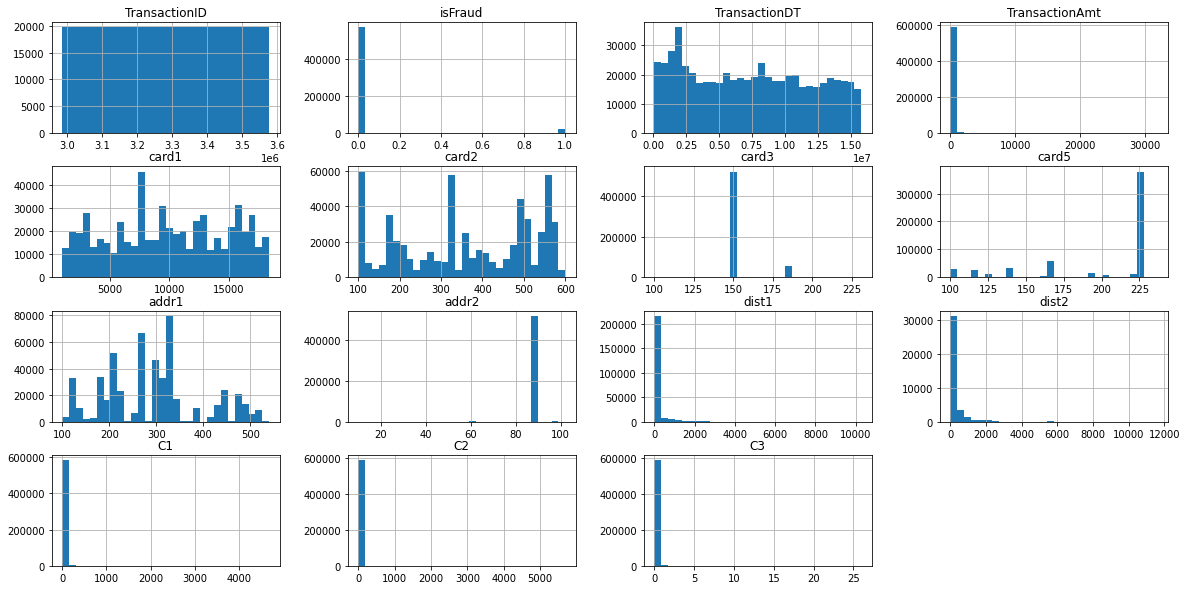

In [ ]:
train[list(train.columns[:20])].hist(bins=30, figsize=(20, 10));

#Data wrangling

In [28]:
def wrangle(df):
  col_dropped_nan = 0
  col_dropped_hom = 0
  for col in df.columns:
    #drop columns with >50% NaN
    if df[col].isnull().sum() > 295270:
      df.drop(columns= [col], inplace= True)
      col_dropped_nan +=1
    #drop columns whose largest class has a proportion >99%
    elif df[col].value_counts().max() > (.99*590540):
      df.drop(columns= [col], inplace= True)
      col_dropped_hom +=1
  print(f'Number of columns dropped due to high NaN: {col_dropped_nan}\n')
  print(f'Number of columns dropped due to high homogenity: {col_dropped_hom}')
  return df

In [29]:
df = wrangle(train)

Number of columns dropped due to high NaN: 214

Number of columns dropped due to high homogenity: 15


In [22]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D10,D11,D15,M1,M2,M3,M4,M6,V1,...,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,NaN,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,13.0,13.0,0.0,T,T,T,M2,T,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,gmail.com,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,M0,T,NaN,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,outlook.com,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,315.0,315.0,T,T,T,M0,F,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,yahoo.com,2.0,5.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,84.0,NaN,111.0,NaN,NaN,NaN,M0,F,NaN,...,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,gmail.com,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
df.shape

(590540, 205)

In [31]:
#upsample minority class
df_not_fraud=df[df.isFraud==0]
df_fraud=df[df.isFraud==1]

df_fraud_upsampled = resample(
    df_fraud,
    replace=True,
    n_samples=len(df_not_fraud),
    random_state=42
)

df_upsampled = pd.concat([df_fraud_upsampled, df_not_fraud])


In [33]:
df_upsampled.isFraud.value_counts(normalize=True)

1    0.5
0    0.5
Name: isFraud, dtype: float64

#XGBoost

In [35]:
target = 'isFraud'
# Split into train and validation data 
y = df_upsampled[target]
X = df_upsampled.drop(columns= target).fillna(-999)
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state = 42)

In [36]:
xgbclf = make_pipeline(OrdinalEncoder(),
                       SimpleImputer(strategy='mean'),
                       xgb.XGBClassifier(
                          n_estimators=1000,
                          max_depth=9,
                          learning_rate=0.05,
                          subsample=0.9,
                          colsample_bytree=0.9,
                          missing=-999,
                          random_state=2019,
                          tree_method='gpu_hist'
                            ))

%time xgbclf.fit(X_train, y_train)

CPU times: user 1min 24s, sys: 1.89 s, total: 1min 26s
Wall time: 1min 26s


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['ProductCD', 'card4', 'card6',
                                      'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
                                      'M6'],
                                mapping=[{'col': 'ProductCD',
                                          'data_type': dtype('O'),
                                          'mapping': C      1
W      2
R      3
H      4
S      5
NaN   -2
dtype: int64},
                                         {'col': 'card4',
                                          'data_type': dtype('O'),
                                          'mapping': visa                1
mastercard          2
-999                3
discover            4
american express    5
NaN                -2
dtype: int64},
                                         {'col': 'card6',
                                          'data_typ...
                                         {'col': 'M4', 'data_type': dtype('O'),
   

In [37]:
val = xgbclf.predict_proba(X_val)[:,-1]
roc_auc_score(y_val, val)

0.9975149557367288

In [46]:
def plot_pre_curve(y_test,probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.')
    plt.title("precision recall curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the plot
    plt.show()
    
def plot_roc(y_test,prob):
    fpr, tpr, thresholds = roc_curve(y_test, prob)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()

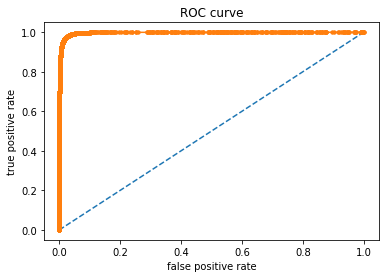

In [47]:
#ROC curve
plot_roc(y_val, val)

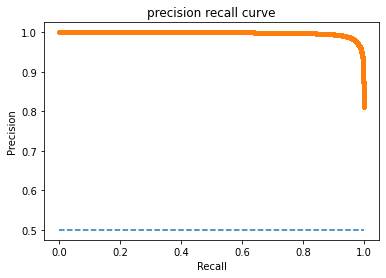

In [44]:
#Precision-Recall curve
plot_pre_curve(y_val, val)